In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# For text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# For model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# For text preprocessing
import nltk

In [2]:
# Cell 2: Download NLTK resources
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to /home/koult/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/koult/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/koult/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Cell 3: Load and combine datasets
# Load the Kaggle dataset
kaggle_df = pd.read_csv('Data/Data.csv')

# Load the ISOT datasets
true_df = pd.read_csv('Data/True.csv')
fake_df = pd.read_csv('Data/Fake.csv')

# Assign labels for ISOT data (consistent with your other notebooks)
true_df['label'] = 1
fake_df['label'] = 0

# Combine the ISOT datasets
isot_df = pd.concat([true_df, fake_df], ignore_index=True)

# Print dataset shapes
print("Kaggle dataset shape:", kaggle_df.shape)
print("ISOT dataset shape:", isot_df.shape)

# Combine Kaggle and ISOT datasets
data = pd.concat([kaggle_df, isot_df], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined dataset shape:", data.shape)

# Handle missing values
data = data.dropna(subset=['text'])
data['title'] = data['title'].fillna("No Title Provided")
if 'author' in data.columns:
    data['author'] = data['author'].fillna("Unknown")

# Create content column like in other implementations
data['content'] = data['title'] + " " + data['text']

Kaggle dataset shape: (20800, 5)
ISOT dataset shape: (44898, 5)
Combined dataset shape: (65698, 7)


In [4]:
# Cell 4: Define text preprocessing function
def preprocess_text(text):
    """
    Preprocess text data by:
    1. Converting to lowercase
    2. Removing URLs
    3. Removing special characters and numbers
    4. Removing punctuation
    5. Tokenizing
    6. Removing stopwords
    7. Lemmatizing words
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    
    return processed_text

In [5]:
# Cell 5: Preprocess the dataset
# Apply preprocessing to a sample to verify
sample = data.iloc[0]['content']
processed_sample = preprocess_text(sample)
print("Original text sample:\n", sample[:200], "...\n")
print("Processed text sample:\n", processed_sample[:200], "...")

# Process all text data (this will take some time)
print("\nPreprocessing all text data (this may take some time)...")
data['processed_content'] = data['content'].apply(preprocess_text)
print("Preprocessing completed!")

Original text sample:
 ‘We’re Just Not Into Her’ – Hillary Clinton Losing Support of Millennials Patrick Henningsen  21st Century WireWhat s up with the millennials? The Clinton campaign may have felt a jolt after seeing th ...

Processed text sample:
 hillary clinton losing support millennials patrick henningsen st century wirewhat millennials clinton campaign may felt jolt seeing front page headline morning wall street journal read millennials coo ...

Preprocessing all text data (this may take some time)...
Preprocessing completed!


In [6]:
# Cell 6: Split data and extract features using TF-IDF
# Split data into features and target
X = data['processed_content']
y = data['label']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Extract TF-IDF features
print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature dimensions: {X_train_tfidf.shape}")

Training set: 52527 samples
Test set: 13132 samples
Extracting TF-IDF features...
TF-IDF feature dimensions: (52527, 10000)


In [7]:
# Cell 7: Train a basic Random Forest model
print("Training Random Forest classifier...")

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, 
                                 max_depth=20,
                                 min_samples_split=10,
                                 min_samples_leaf=5,
                                 random_state=42,
                                 n_jobs=-1)  # Use all available cores

# Train the model
rf_model.fit(X_train_tfidf, y_train)

print("Random Forest training completed!")

Training Random Forest classifier...
Random Forest training completed!


Random Forest Test Accuracy: 0.9111
Random Forest Test Precision: 0.9649
Random Forest Test Recall: 0.8471
Random Forest Test F1-Score: 0.9022

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      6774
           1       0.96      0.85      0.90      6358

    accuracy                           0.91     13132
   macro avg       0.92      0.91      0.91     13132
weighted avg       0.92      0.91      0.91     13132



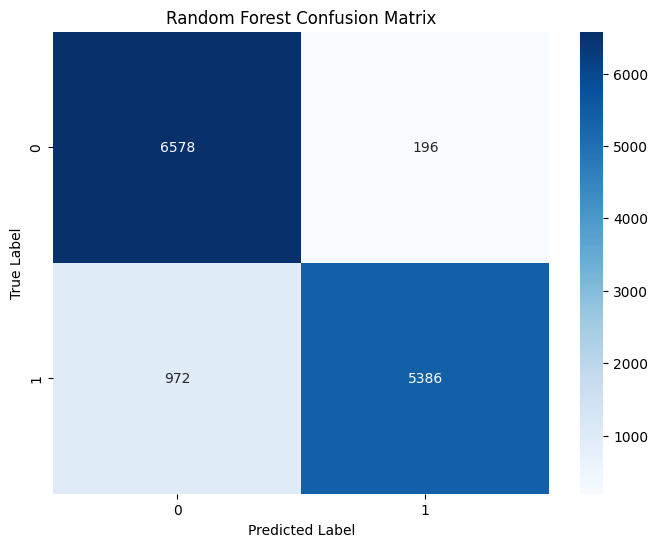

In [8]:
# Cell 8: Evaluate the model on test data
# Make predictions on test data
y_pred = rf_model.predict(X_test_tfidf)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"Random Forest Test Accuracy: {accuracy:.4f}")
print(f"Random Forest Test Precision: {precision:.4f}")
print(f"Random Forest Test Recall: {recall:.4f}")
print(f"Random Forest Test F1-Score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()